In [1]:
using DrWatson
@quickactivate "BayesWorkshop2021"
include(joinpath(srcdir(), "setup.jl"));

## Hierarchical modeling

### Modeling varying intercepts for each building

Let's add a hierarchical intercept parameter, $\alpha_b$ at the building level to our model.

$$
\text{complaints}_{b,t} \sim \text{Neg-Binomial}(\lambda_{b,t}, \phi) \\
\lambda_{b,t}  = \exp{(\eta_{b,t})} \\
\eta_{b,t} = \mu_b + \beta \, {\rm traps}_{b,t} + \beta_{\rm super}\, {\rm super}_b + \text{log_sq_foot}_b \\
\mu_b \sim \text{Normal}(\alpha, \sigma_{\mu})
$$

In our Stan model, $\mu_b$ is the $b$-th element of the vector $\texttt{mu}$ which has one element per building.

One of our predictors varies only by building, so we can rewrite the above model more efficiently like so:

$$
\eta_{b,t} = \mu_b + \beta \, {\rm traps}_{b,t} + \text{log_sq_foot}_b\\
\mu_b \sim \text{Normal}(\alpha +  \beta_{\text{super}} \, \text{super}_b , \sigma_{\mu})
$$

We have more information at the building level as well, like the average age of the residents, the average age of the buildings, and the average per-apartment monthly rent so we can add that data into a matrix called `building_data`, which will have one row per building and four columns:

  * `live_in_super`
  * `age_of_building`
  * `average_tentant_age`
  * `monthly_average_rent`

We'll write the Stan model like:

$$
\eta_{b,t} = \alpha_b + \beta \, {\rm traps} + \text{log_sq_foot}\\
\mu \sim \text{Normal}(\alpha + \texttt{building_data} \, \zeta, \,\sigma_{\mu})
$$

### Prepare building data for hierarchical

We'll need to do some more data prep before we can fit our models. Firstly to use the building variable in Stan we will need to transform it from a factor variable to an integer variable.

In [2]:
include(joinpath(srcdir(), "building_data.jl"))
building_data

┌ Warning: RCall.jl: 
│ Attaching package: ‘dplyr’
│ 
│ The following objects are masked from ‘package:stats’:
│ 
│     filter, lag
│ 
│ The following objects are masked from ‘package:base’:
│ 
│     intersect, setdiff, setequal, union
│ 
└ @ RCall /home/tor/.julia/packages/RCall/iMDW2/src/io.jl:160
┌ Warning: RCall.jl: 
│ Attaching package: ‘lubridate’
│ 
│ The following objects are masked from ‘package:base’:
│ 
│     date, intersect, setdiff, union
│ 
└ @ RCall /home/tor/.julia/packages/RCall/iMDW2/src/io.jl:160


10×5 Matrix{Float64}:
 -0.3  -0.24  -0.805592   0.395347    0.159693
 -0.3  -0.64  -0.275426  -0.0357335  -0.12374
 -0.3  -0.04   2.13937   -0.206569   -0.658587
 -0.3   0.16  -0.154987  -0.258725    0.331981
  0.7  -0.04   0.815208  -0.47869    -0.0106459
 -0.3  -0.04   2.88446   -0.137937   -0.309452
 -0.3   0.96  -0.320668  -0.878173    0.183439
  0.7  -0.14  -2.27957    1.52587     0.176402
 -0.3   1.06  -3.00312    0.853178    0.152982
  0.7  -1.04   1.00032   -0.778571    0.0979279

### Fit the hierarchical model

Fit the model to data.

In [3]:
using Turing

HalfNormal(args...) = truncated(Normal(args...), 1e-6, Inf)

function NegativeBinomial2(μ, ϕ)
    p = 1 / (1 + μ / ϕ)
    r = ϕ

    return NegativeBinomial(r, p)
end

@model function hier_NB_regression(; traps, live_in_super, log_sq_foot, building_idx, building_data, complaints=missing)
    J, K = size(building_data)

    sigma_mu ~ HalfNormal() # standard deviation of building-specific intercepts
    alpha ~ Normal(log(4), 1) # intercept of model for mu
    zeta ~ filldist(Normal(), K)  # coefficients on building-level predictors in model for mu
    beta ~ Normal(-0.25, 1) # coefficient on traps
    inv_phi ~ HalfNormal() # 1/phi (easier to think about prior for 1/phi instead of phi)

    mu ~ MvNormal(alpha .+ building_data * zeta, sigma_mu)


    # Allocate if we're going to sample.
    complaints = complaints === missing ? Vector{Int}(undef, length(traps)) : complaints
    @. complaints ~ NegativeBinomial2(
        clamp(exp(mu[building_idx] + beta * traps + log_sq_foot), 1e-3, 1e5),
        clamp(inv(inv_phi), 1e-3, 100)
    )
    return (; sigma_mu, alpha, zeta, beta, mu, inv_phi, complaints)
end

hier_NB_regression (generic function with 1 method)

In [4]:
# Add the `log_sq_foot` as in 02.
transform!(pest_data, :total_sq_foot => ByRow(total_sq_foot -> log(total_sq_foot / 1e4)) => :log_sq_foot)

obs = (
    traps = pest_data.traps,
    live_in_super = pest_data.live_in_super,
    log_sq_foot = pest_data.log_sq_foot,
    building_idx = pest_data.building_idx,
    building_data = building_data
);
post = sample(hier_NB_regression(; obs..., complaints=pest_data.complaints), NUTS(), 1_000);

┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /home/tor/.julia/packages/Turing/YGtAo/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06


### Diagnostics

We get a bunch of warnings from Turing about divergent transitions, which is an indication that there may be regions of the posterior that have not been explored by the Markov chains.

Divergences are discussed in more detail in the course slides as well as the **bayesplot** (MCMC diagnostics vignette)[http://mc-stan.org/bayesplot/articles/visual-mcmc-diagnostics.html] and [*A Conceptual Introduction to Hamiltonian Monte Carlo*](https://arxiv.org/abs/1701.02434).

In this example we will see that we have divergent transitions because we need to reparameterize our model - i.e., we will retain the overall structure of the model, but transform some of the parameters so that it is easier for Stan to sample from the parameter space. Before we go through exactly how to do this reparameterization, we will first go through what indicates that this is something that reparameterization will resolve. We will go through:

1. Examining the fitted parameter values, including the effective sample size
2. Traceplots and scatterplots that reveal particular patterns in locations of the divergences.

First the chain:

In [5]:
post

Chains MCMC chain (1000×31×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 29.92 seconds
Compute duration  = 29.92 seconds
parameters        = inv_phi, alpha, mu[1], sigma_mu, zeta[3], mu[6], mu[8], mu[3], mu[9], mu[7], zeta[4], mu[2], zeta[1], zeta[5], mu[5], zeta[2], beta, mu[4], mu[10]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

    sigma_mu    0.3338    0.1857     0.0059    0.0127   162.5921    1.0004     ⋯
       alpha    1.0439    0.4597     0.0145    0.0489    65.2494    1.0584     ⋯
     zeta[1]    0.0560    0.3430     0.0108    0.0100   584.8127    1.0012     ⋯
     ze

You can see that the effective samples are somewhat low for many of the parameters relative to the total number of samples. This alone isn't indicative of the need to reparameterize, but it indicates that we should look further at the trace plots and pairs plots. First let's look at the traceplots to see if the divergent transitions form a pattern.

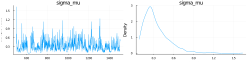

In [6]:
using StatsPlots
plot(post[[:sigma_mu]])

In [7]:
# NOTE: If it fails because of argument error, just run until it doesn't.
# The prior is somewhat numerically unstable.
idata = to_arviz(
    hier_NB_regression(; obs...), # prior model
    hier_NB_regression(; obs..., complaints=pest_data.complaints), # conditioned model
    post # posterior samples
)

InferenceData with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> sample_stats_prior
	> observed_data

Looks as if the divergent parameters, the little black bars underneath the traceplots correspond to samples where the sampler gets stuck at one parameter value for $\sigma_\mu$.

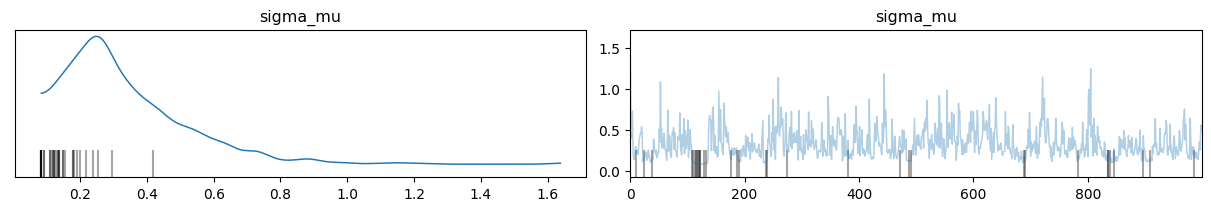

1×2 Matrix{PyCall.PyObject}:
 PyObject <AxesSubplot:title={'center':'sigma_mu'}>  …  PyObject <AxesSubplot:title={'center':'sigma_mu'}>

In [8]:
plot_trace(idata, var_names=["sigma_mu"])

And we can look at the joint distribution of `sigma_mu` with one of the means:

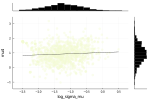

In [9]:
let
    df = transform(
        DataFrame(post[[:sigma_mu, Symbol("mu[4]")]]),
        :sigma_mu => ByRow(log) => :log_sigma_mu,
        # `StatsPlots.@df` isn't to happy about `Symbol(...)`, so we
        # just rename it to `:mu4`.
        Symbol("mu[4]") => identity => :mu4
    )
    @df df cornerplot([:log_sigma_mu :mu4], compact=true)
end

What we have here is a cloud-like shape, with most of the divergences clustering towards the bottom. We'll see a bit later that we actually want this to look more like a funnel than a cloud, but the divergences are indicating that the sampler can't explore the narrowing neck of the funnel.

One way to see why we should expect some version of a funnel is to look at some simulations from the prior, which we can do without MCMC and thus with no risk of sampling problems:

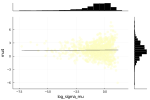

In [10]:
prior_samples = sample(hier_NB_regression(; obs..., complaints=pest_data.complaints), Prior(), 1_000);
let chain = prior_samples
    df = transform(
        DataFrame(chain[[:sigma_mu, Symbol("mu[4]")]]),
        :sigma_mu => ByRow(log) => :log_sigma_mu,
        # `StatsPlots.@df` isn't to happy about `Symbol(...)`, so we
        # just rename it to `:mu4`.
        Symbol("mu[4]") => identity => :mu4
    )
    @df df cornerplot([:log_sigma_mu :mu4], compact=true)
end

Of course, if the data is at all informative we shouldn't expect the posterior to look exactly like the prior. But unless the data is incredibly informative about the parameters and the posterior concentrates away from the narrow neck of the funnel, the sampler is going to have to confront the funnel geometry. (See the [Visual MCMC Diagnostics](http://mc-stan.org/bayesplot/articles/visual-mcmc-diagnostics.html) vignette for more on this.)

Another way to look at the divergences is via a parallel coordinates plot:

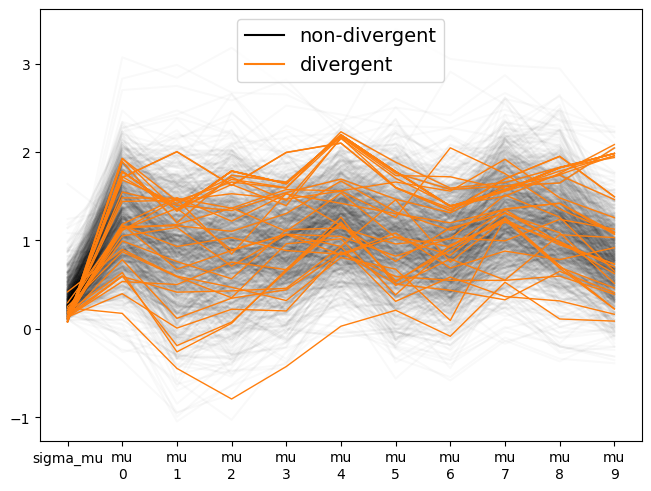

PyObject <AxesSubplot:>

In [11]:
plot_parallel(idata, var_names=["sigma_mu", "mu"])

Again, we see evidence that our problems concentrate when $\texttt{sigma_mu}$ is small.

### Reparameterize and recheck diagnostics

Instead, we should use the non-centered parameterization for $\mu_b$. We define a vector of auxiliary variables in the parameters block, $\texttt{mu_raw}$ that is given a $\text{Normal}(0, 1)$ prior in the model block. We then make $\texttt{mu}$ a transformed parameter: We can reparameterize the random intercept $\mu_b$, which is distributed:

$$
\mu_b \sim \text{Normal}(\alpha + \texttt{building_data} \, \zeta, \sigma_{\mu})
$$

This gives $\texttt{mu}$ a $\text{Normal}(\alpha + \texttt{building_data}\, \zeta, \sigma_\mu)$ distribution, but it decouples the dependence of the density of each element of $\texttt{mu}$ from $\texttt{sigma_mu}$ ($\sigma_\mu$). We will examine the effective sample size of the fitted model to see whether we've fixed the problem with our reparameterization.

Fit the model to the data.

In [12]:
@model function hier_NB_regression_ncp(; traps, live_in_super, log_sq_foot, building_idx, building_data, complaints=missing)
    J, K = size(building_data)

    sigma_mu ~ HalfNormal()
    alpha ~ Normal(log(4), 1)
    zeta ~ filldist(Normal(), K)  # could also use informative priors on the different elements
    beta ~ Normal(-0.25, 1)
    inv_phi ~ HalfNormal()
    mu_raw ~ filldist(Normal(), J)

    mu  = alpha .+ building_data * zeta .+ sigma_mu .* mu_raw

    # Allocate if we're going to sample.
    complaints = complaints === missing ? Vector{Int}(undef, length(traps)) : complaints
    @. complaints ~ NegativeBinomial2(
        clamp(exp(mu[building_idx] + beta * traps + log_sq_foot), 1e-3, 1e5),
        clamp(inv(inv_phi), 1e-3, 100)
    )
    return (; sigma_mu, alpha, zeta, beta, mu, inv_phi, complaints)
end

hier_NB_regression_ncp (generic function with 1 method)

Examining the fit of the new model

In [13]:
post_ncp = sample(hier_NB_regression_ncp(; obs..., complaints=pest_data.complaints), NUTS(), 1_000);

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/tor/.julia/packages/Turing/YGtAo/src/inference/hmc.jl:188
Sampling:  20%|████████                                 |  ETA: 0:00:12┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/tor/.julia/packages/AdvancedHMC/bv9VV/src/hamiltonian.jl:47
Sampling:  23%|█████████▌                               |  ETA: 0:00:11┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/tor/.julia/packages/AdvancedHMC/bv9VV/src/hamiltonian.jl:47
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06


This has improved the effective sample sizes of $\texttt{mu}$. We now run our usual posterior predictive checks.

In [14]:
idata_ncp = to_arviz(
    hier_NB_regression_ncp(; obs...), # prior model
    hier_NB_regression_ncp(; obs..., complaints=pest_data.complaints), # conditioned model
    post_ncp # posterior samples
)

InferenceData with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> sample_stats_prior
	> observed_data

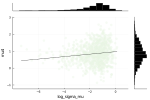

In [15]:
# Now that `mu` isn't on the LHS of a `~` anymore, it won't be present in
# the resulting chain. Instead we need to extract it using `generated_quantities`:
generated = generated_quantities(
    hier_NB_regression_ncp(; obs..., complaints=pest_data.complaints),
    MCMCChains.get_sections(post_ncp, :parameters)
);

let
    # Extract `mu[4]` from `generated`.
    mu4 = mapreduce(vcat, generated) do g
        g.mu[4]
    end

    # Construct the `DataFrame`.
    df = select(
        DataFrame(post_ncp[[:sigma_mu]]),
        :sigma_mu => ByRow(log) => :log_sigma_mu,
    )
    # Add `mu[4]` to the `DataFrame.`
    df = DataFrame(:log_sigma_mu => df.log_sigma_mu, :mu4 => mu4)
    # Plot!
    @df df cornerplot([:log_sigma_mu :mu4], compact=true)
end

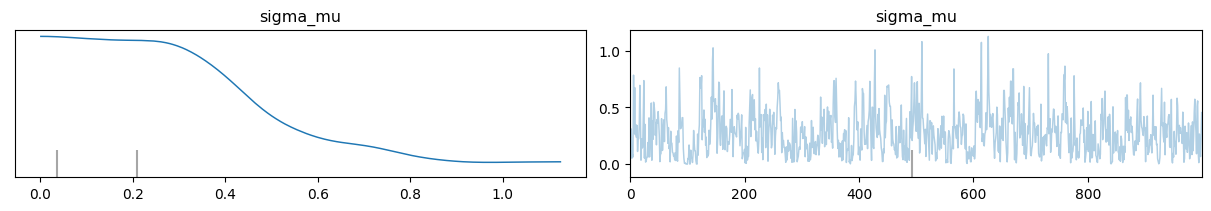

1×2 Matrix{PyCall.PyObject}:
 PyObject <AxesSubplot:title={'center':'sigma_mu'}>  …  PyObject <AxesSubplot:title={'center':'sigma_mu'}>

In [16]:
plot_trace(idata_ncp, var_names=["sigma_mu"])

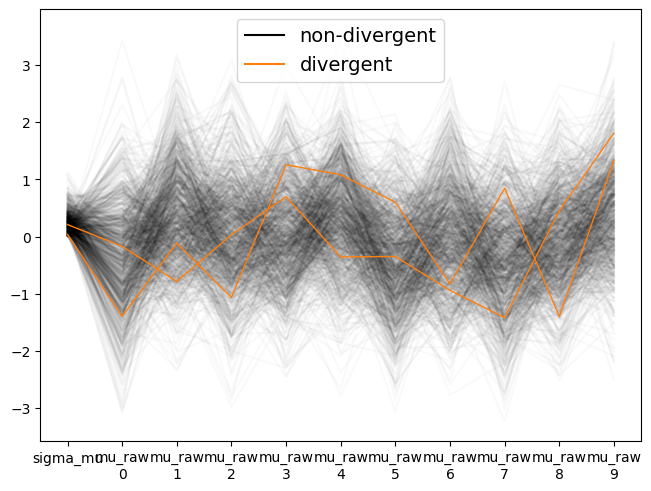

PyObject <AxesSubplot:>

In [17]:
plot_parallel(idata_ncp, var_names=["sigma_mu", "mu_raw"])

Notice how the numerical errors are now much reduced (depending on your random seed, they might be completely gone!).

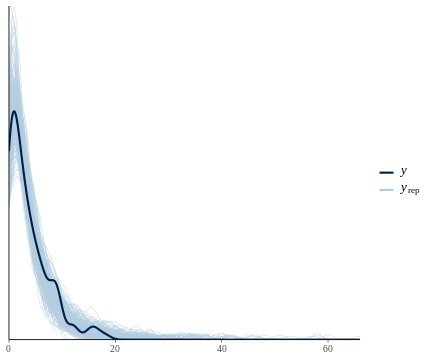

RObject{VecSxp}


In [18]:
yrep = posterior_predictive(hier_NB_regression_ncp(; obs...), post_ncp)
ppc_dens_overlay(pest_data.complaints, yrep[1:200])

This looks quite nice. If we've captured the building-level means well, then the posterior distribution of means by building should match well with the observed means of the quantity of building complaints by month.

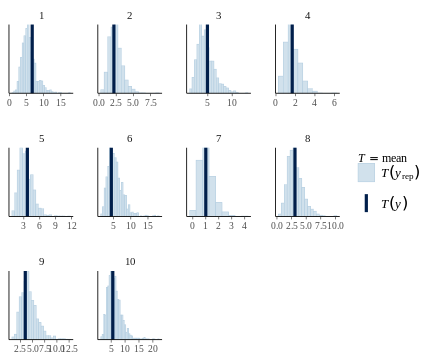

RObject{VecSxp}


In [19]:
ppc_stat_grouped(pest_data.complaints, yrep, group=pest_data.building_idx, stat="mean", binwidth=0.5)

We weren't doing terribly with the building-specific means before, but now they are all well-captured by our model. The model is also able to do a decent job estimating within-building variability:

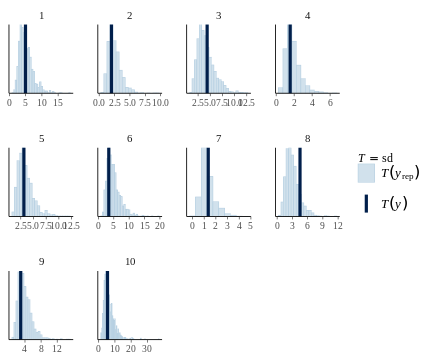

RObject{VecSxp}


In [20]:
ppc_stat_grouped(pest_data.complaints, yrep, group=pest_data.building_idx, stat="sd", binwidth=0.5)

Predictions by number of traps:

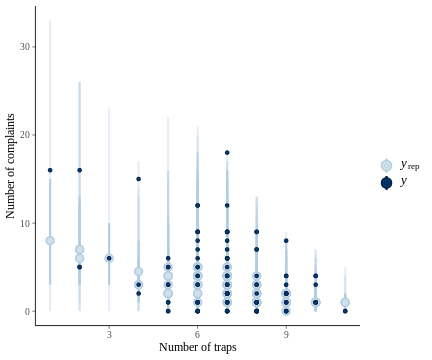

RObject{VecSxp}


In [21]:
using RCall
ggplot = rimport("ggplot2")

ppc_intervals(pest_data.complaints, yrep, x=pest_data.traps) + ggplot.labs(x = "Number of traps", y = "Number of complaints")

Standardized residuals:

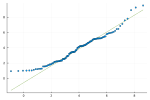

In [22]:
# Convert into a matrix of size `(num_variables, num_samples)`
yrep_matrix = mapreduce(hcat, yrep) do y
    y.complaints
end;

qqnorm(dropdims(mean(yrep_matrix; dims=2); dims=2), qqline=:R)

Rootogram:

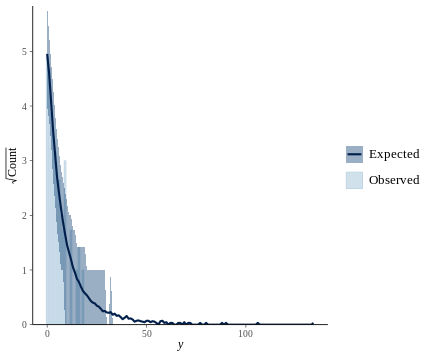

RObject{VecSxp}


In [23]:
ppc_rootogram(pest_data.complaints, yrep)

### Varying intercepts *and* varying slopes

We've gotten some new data that extends the number of time points for which we have observations for each building. This will let us explore how to expand the model a bit more with varying *slopes* in addition to the varying intercepts and also, later, also model temporal variation.

In [24]:
let path = datadir("pest_data_longer_stan_dat.rds")
    R"""
    stan_dat_hier <- readRDS($path)
    """
end
pest_data_longer = rcopy(R"stan_dat_hier")
pest_data_longer = (; pairs(pest_data_longer)...)
pest_data_longer = merge(
    pest_data_longer, 
    (complaints = Int.(pest_data_longer.complaints), traps = Int.(pest_data_longer.traps))
)

(complaints = [1, 0, 1, 1, 0, 1, 2, 0, 4, 4  …  0, 0, 1, 0, 0, 0, 0, 0, 0, 0], traps = [7, 7, 7, 7, 7, 7, 6, 7, 8, 8  …  14, 13, 14, 13, 12, 12, 13, 14, 15, 16], pred_mat = [0.0 4.7 5.387742357476312 3.8469490497533783; 0.0 4.7 5.387742357476312 3.8469490497533783; … ; 1.0 3.9 4.213823991757655 3.7851835479577094; 1.0 3.9 4.213823991757655 3.7851835479577094], N = 360, K = 4.0, log_sq_foot = [1.4156605451137438, 1.4156605451137438, 1.4156605451137438, 1.4156605451137438, 1.4156605451137438, 1.4156605451137438, 1.4156605451137438, 1.4156605451137438, 1.4156605451137438, 1.4156605451137438  …  1.7792014375670486, 1.7792014375670486, 1.7792014375670486, 1.7792014375670486, 1.7792014375670486, 1.7792014375670486, 1.7792014375670486, 1.7792014375670486, 1.7792014375670486, 1.7792014375670486], mo_idx = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  27, 28, 29, 30, 31, 32, 33, 34, 35, 36], M = 36.0, J = 10, building_idx = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  10, 10, 10, 10, 10, 10, 10, 10, 10, 10], log_sq_

Perhaps if the levels of complaints differ by building, the coefficient for the effect of traps on building does too. We can add this to our model and observe the fit.

$$
\text{complaints}_{b,t} \sim \text{Neg-Binomial}(\lambda_{b,t}, \phi)  \\
\lambda_{b,t} = \exp{(\eta_{b,t})}\\
\eta_{b,t} = \mu_b + \kappa_b \, \texttt{traps}_{b,t} + \text{log_sq_foot}_b \\
\mu_b \sim \text{Normal}(\alpha + \texttt{building_data} \, \zeta, \sigma_{\mu}) \\
\kappa_b \sim \text{Normal}(\beta + \texttt{building_data} \, \gamma, \sigma_{\kappa})
$$

Fit the model to data and extract the posterior draws needed for our posterior predictive checks.

In [40]:
@model function hier_NB_regression_ncp_slopes(; traps, log_sq_foot, building_idx, building_data, complaints=missing)
    J, K = size(building_data)

    kappa_raw ~ filldist(Normal(), J)
    sigma_kappa ~ HalfNormal()
    gamma ~ filldist(Normal(), K)

    sigma_mu ~ HalfNormal()
    alpha ~ Normal(log(4), 1)
    zeta ~ filldist(Normal(), K)  # could also use informative priors on the different elements
    beta ~ Normal(-0.25, 1)
    inv_phi ~ HalfNormal()
    mu_raw ~ filldist(Normal(), J)

    mu  = alpha .+ building_data * zeta .+ sigma_mu * mu_raw
    kappa = beta .+ building_data * gamma .+ sigma_kappa * kappa_raw;

    # Allocate if we're going to sample.
    complaints = complaints === missing ? Vector{Int}(undef, length(traps)) : complaints
    @. complaints ~ NegativeBinomial2(
        clamp(exp(mu[building_idx] + kappa[building_idx] * traps + log_sq_foot), 1e-3, 1e5),
        clamp(inv(inv_phi), 1e-3, 100)
    )
    return (; sigma_mu, sigma_kappa, gamma, alpha, zeta, beta, mu, kappa, inv_phi, complaints)
end

hier_NB_regression_ncp_slopes (generic function with 1 method)

In [41]:
obs = (
    traps = pest_data_longer.traps,
    log_sq_foot = pest_data_longer.log_sq_foot,
    building_idx = pest_data_longer.building_idx,
    building_data = building_data
);

post_ncp_slopes = sample(hier_NB_regression_ncp_slopes(; obs..., complaints=pest_data_longer.complaints), NUTS(), 1_000)

┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /home/tor/.julia/packages/Turing/YGtAo/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:40


Chains MCMC chain (1000×47×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 108.42 seconds
Compute duration  = 108.42 seconds
parameters        = inv_phi, sigma_kappa, alpha, kappa_raw[7], gamma[4], sigma_mu, mu_raw[9], mu_raw[10], kappa_raw[5], kappa_raw[6], mu_raw[5], zeta[3], mu_raw[4], mu_raw[2], mu_raw[6], mu_raw[3], kappa_raw[10], gamma[5], mu_raw[7], gamma[2], kappa_raw[8], gamma[3], zeta[4], zeta[1], kappa_raw[9], zeta[5], kappa_raw[1], gamma[1], mu_raw[1], zeta[2], beta, mu_raw[8], kappa_raw[2], kappa_raw[4], kappa_raw[3]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
     parameters      mean       std   naive_se      mcse         ess      rhat ⋯
         Symbol   Float64   Float64    Float64   Float64     Float64   Float64 ⋯

   k

To see if the model infers building-to-building differences in, we can plot a histogram of our marginal posterior distribution for `sigma_kappa`.

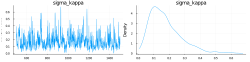

In [42]:
plot(post_ncp_slopes[[:sigma_kappa]])

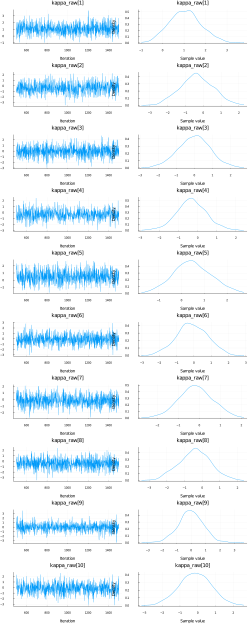

In [43]:
plot(MCMCChains.group(post_ncp_slopes, :kappa_raw))

While the model can't specifically rule out zero from the posterior, it does have mass at small non-zero numbers, so we should leave in the hierarchy over $\texttt{kappa}$. Plotting the marginal data density again, we can see the model still looks well calibrated.

In [44]:
yrep = posterior_predictive(hier_NB_regression_ncp_slopes(; obs...), post_ncp_slopes)

1000-element Vector{NamedTuple{(:complaints,), Tuple{SubArray{Float64, 1, Matrix{Float64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}}}}:
 (complaints = [1.0, 0.0, 0.0, 4.0, 4.0, 5.0, 4.0, 3.0, 2.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],)
 (complaints = [2.0, 4.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 4.0, 6.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],)
 (complaints = [6.0, 0.0, 10.0, 0.0, 7.0, 15.0, 0.0, 2.0, 8.0, 4.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],)
 (complaints = [2.0, 5.0, 1.0, 3.0, 0.0, 3.0, 0.0, 2.0, 8.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],)
 (complaints = [1.0, 1.0, 0.0, 0.0, 3.0, 1.0, 5.0, 4.0, 19.0, 8.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],)
 (complaints = [2.0, 2.0, 2.0, 7.0, 6.0, 1.0, 1.0, 2.0, 7.0, 5.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],)
 (complaints = [0.0, 1.0, 0.0, 14.0, 0.0, 3.0, 0.0, 3.0, 4.0, 1.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],)
 (c

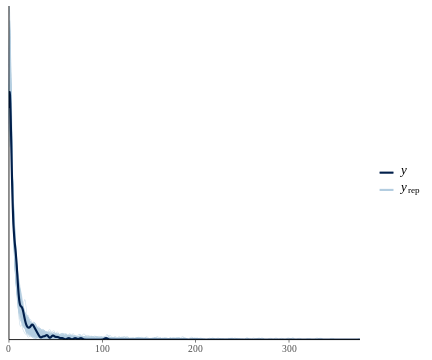

RObject{VecSxp}


In [45]:
ppc_dens_overlay(pest_data_longer.complaints, yrep[1:200])

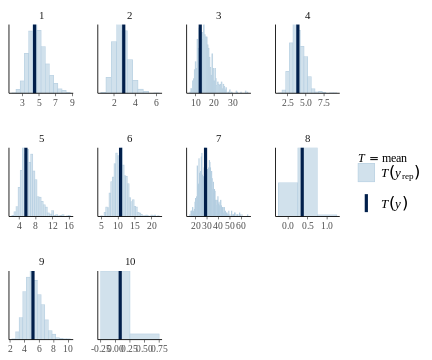

RObject{VecSxp}


In [46]:
ppc_stat_grouped(pest_data_longer.complaints, yrep, group=pest_data_longer.building_idx, stat="mean", binwidth=0.5)

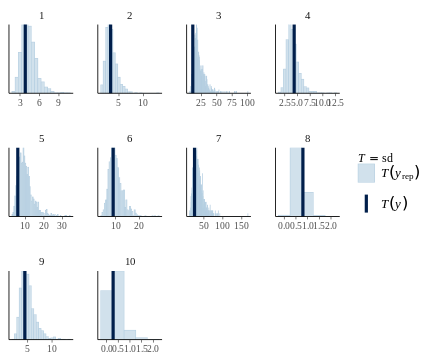

RObject{VecSxp}


In [47]:
ppc_stat_grouped(pest_data_longer.complaints, yrep, group=pest_data_longer.building_idx, stat="sd", binwidth=0.5)

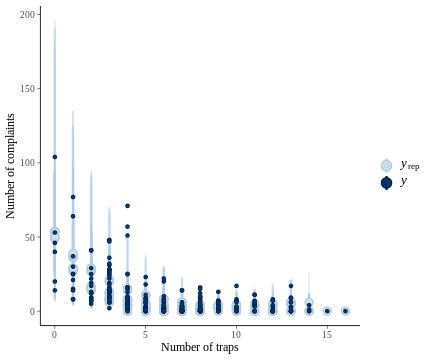

RObject{VecSxp}


In [48]:
ppc_intervals(pest_data_longer.complaints, yrep, x=pest_data_longer.traps) + ggplot.labs(x = "Number of traps", y = "Number of complaints")

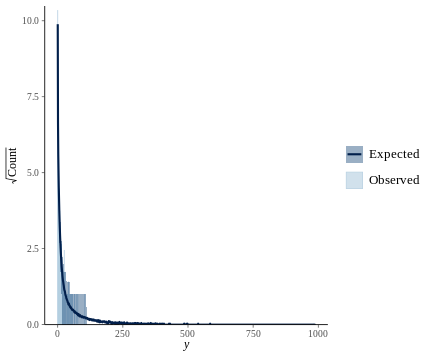

RObject{VecSxp}


In [49]:
ppc_rootogram(pest_data_longer.complaints, yrep)